In [22]:
import os 
os.chdir("C:\\Users\\Pieter-Jan\\Documents\\Carreer\\Candriam\\nlp\\ESG\\topic_sentiment_analysis")

# Libraries

In [23]:
# data manipulations
import pandas as pd
import numpy as np
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import joblib

# Sklearn and modelling
from sklearn.feature_extraction import text
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation as LDA

# LDA
import pyLDAvis
import pyLDAvis.sklearn
pyLDAvis.enable_notebook()

# own modules
import modules.preprocessing as preprocess

In [24]:
%reload_ext autoreload
%autoreload 2

# Read in data and process data in sentences/paragraphs

In [25]:
df_url = pd.read_csv("data/ticker_url.csv", sep=";")
df_url["article"] = df_url["url"].apply(preprocess.extract_content, open_pdf_file=None) 
df_text = df_url.dropna().reset_index(drop=True)

In [26]:
df_text.shape

(32, 3)

## Load spacy model

In [27]:
nlp = preprocess.load_spacy_model()

✔ Download and installation successful
You can now load the model via spacy.load('en_core_web_sm')


## Make sentences

In [28]:
df_text["sentences"] = df_text["article"].apply(preprocess.extract_statements, make_sentence=False)
df_sent = [pd.DataFrame.from_dict({"company": df_text["company"][i], "sentence": s}) for i, s in enumerate(df_text["sentences"])]
df_sent = pd.concat(df_sent)
df_sent["lem"] = df_sent['sentence'].apply(preprocess.lemmatize, nlp=nlp)

## Remove stopwords

In [29]:
# add stop words
fsi_stop_words = [
  'plc', 'group', 'target',
  'track', 'capital', 'holding',
  'report', 'annualreport',
  'esg', 'bank', 'report',
  'annualreport', 'long', 'make',
  'company', 'business',
  'support', 'provide',
  'chase', 'goldman', 
  'jp', 'morgan', 'sachs', 
  'stanley','jpmorgan', 
  'barclays', 'johnson'
]

fsi_stop_words = fsi_stop_words + df_sent["company"].unique().tolist()

# our list contains all english stop words + companies names + specific keywords
stop_words = text.ENGLISH_STOP_WORDS.union(fsi_stop_words)

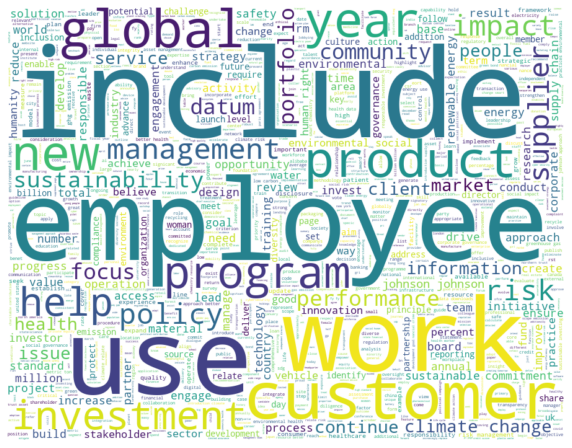

In [30]:
large_string = ' '.join(df_sent.lem)

# use 3rd party lib to compute term freq., apply stop words
word_cloud = WordCloud(
    background_color="white",
    max_words=5000, 
    width=900, 
    height=700, 
    stopwords=stop_words, 
    contour_width=3, 
    contour_color='steelblue'
)

# display our wordcloud across all records
plt.figure(figsize=(10,10))
word_cloud.generate(large_string)
plt.imshow(word_cloud, interpolation='bilinear')
plt.axis("off")
plt.show()

## Embed features and train model

In [60]:
word_tf_vectorizer = CountVectorizer(stop_words=stop_words, ngram_range=(1,1))
word_tf = word_tf_vectorizer.fit_transform(df_sent.lem)

In [50]:
len(word_tf_vectorizer.vocabulary_)

136708

In [61]:
# Train a LDA model with n_topics topics
n_topics = 10
lda = LDA(random_state = 42, n_components = n_topics, learning_decay = .3)
lda_fitted = lda.fit(word_tf)

# Save models

In [62]:
# save countvec
filename = 'trained_models/CountVectorizer.sav'
joblib.dump(word_tf_vectorizer, filename)

# save LDA model
filename = 'trained_models/lda_fitted.sav'
joblib.dump(lda, filename)

['trained_models/lda_fitted.sav']

## Show topics

In [63]:
# Retrieve top N words describing each of our 9 topics
def top_words(model, feature_names, n_top_words):
    
    rows = []
    for topic_idx, topic in enumerate(model.components_):
            message = ", ".join([feature_names[i] for i in topic.argsort()[:-n_top_words - 1:-1]])
            rows.append(["Topic #%d: " % (topic_idx + 1), message])
          
    return pd.DataFrame(rows, columns=['topic', 'keywords'])

# Display topics keywords for inspection and for us to label topics
tf_feature_names = word_tf_vectorizer.get_feature_names()
top_words(lda, tf_feature_names, 15)

,topic,keywords
0,Topic #1:,"health, johnson, humanity, safety, environment..."
1,Topic #2:,"assurance, social, information, datum, page, m..."
2,Topic #3:,"water, total, security, source, million, prote..."
3,Topic #4:,"investment, sustainable, client, asset, sustai..."
4,Topic #5:,"board, management, governance, risk, committee..."
5,Topic #6:,"employee, community, diversity, people, work, ..."
6,Topic #7:,"customer, emission, use, scope, vehicle, ghg, ..."
7,Topic #8:,"energy, use, renewable, product, waste, projec..."
8,Topic #9:,"health, johnson, patient, new, healthcare, acc..."
9,Topic #10:,"risk, climate, environmental, social, policy, ..."


In [64]:
vis_data = pyLDAvis.sklearn.prepare(lda, word_tf, word_tf_vectorizer, mds='tsne')
pyLDAvis.save_html(vis_data, 'output/output_filename.html')
vis_data

PreparedData(topic_coordinates=               x          y  topics  cluster       Freq
topic                                                  
9      32.420952   8.115230       1        1  17.699276
3       0.648955  71.707100       2        1  15.063033
5      71.019684   9.971006       3        1  13.197220
4       3.785981  33.185135       4        1  12.475337
7     -42.666500  -9.222070       5        1  10.346995
6      -3.621689 -43.526516       6        1   9.896300
8      -3.632402  -4.171708       7        1   7.935475
1     -36.584400  35.804413       8        1   6.036382
0      44.391380  50.615383       9        1   5.542570
2      40.235809 -31.591665      10        1   1.807412, topic_info=             Term         Freq        Total Category  logprob  loglift
5732       health  1146.000000  1146.000000  Default  30.0000  30.0000
6876      johnson   822.000000   822.000000  Default  29.0000  29.0000
4211       energy  1067.000000  1067.000000  Default  28.0000  28.0000
6656   investment  1151.000000  1151.000000  Default  27.0000  27.0000
13492       water   478.000000   478.000000  Default  26.0000  26.0000
...           ...          ...          ...      ...      ...      ...
9263   percentage    10.430899   121.589819  Topic10  -5.9360   1.5574
1241         base    12.051197   514.648923  Topic10  -5.7916   0.2590
3186         data    11.142313   307.809368  Topic10  -5.8701   0.6945
8596       number    10.790693   338.902096  Topic10  -5.9021   0.5662
2176        china     9.895957   165.213349  Topic10  -5.9887   1.1982

[743 rows x 6 columns], token_table=       Topic      Freq    Term
term                          
5         10  0.911295    aaca
13        10  0.846472   abaco
76         1  0.063095  access
76         2  0.066249  access
76         3  0.176665  access
...      ...       ...     ...
13800      8  0.064876    year
13800      9  0.027112    year
13800     10  0.007746    year
13814      8  0.186414     yes
13814      9  0.792259     yes

[2139 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[10, 4, 6, 5, 8, 7, 9, 2, 1, 3])

## Performance on new data

In [65]:
# new example
new_data = df_sent[df_sent.company=="barclays"].lem
word_tf_new = word_tf_vectorizer.transform(new_data)

In [66]:
# predict
transformed = lda_fitted.transform(word_tf_new)
# topic with highest probability
# add 1 (start otherwise at 0)
a = [np.argmax(distribution) + 1 for distribution in transformed]
# with associated probability
b = [np.max(distribution) for distribution in transformed]

# consolidate LDA output into a handy dataframe 
df1 = pd.DataFrame(new_data)
df1["nr_words"] = df1["lem"].apply(lambda x: len(x.split()))
df2 = pd.DataFrame(zip(a,b,transformed), columns=['topic', 'probability', 'probabilities'])
esg_group = pd.concat([df1, df2], axis=1)

# display dataframe
esg_group.head()

,lem,nr_words,topic,probability,probabilities
0,barclays plc environmental social governance r...,94,10,0.598411,"[0.0022730107138114477, 0.2311564228260628, 0...."
1,barclays plc environmental social governance r...,49,10,0.834275,"[0.0034486390066639735, 0.0034488958657378026,..."
2,barclays plc environmental social governance r...,123,5,0.818044,"[0.001449585550656578, 0.1160333418780411, 0.0..."
3,barclays ukbarclays internationaluk retail and...,157,10,0.866529,"[0.0010001056510791086, 0.001000146717648425, ..."
4,in september barclays join other bank in pilot...,64,10,0.829264,"[0.002564690981047567, 0.002564503907532736, 0..."


In [67]:
esg_group[esg_group.topic==6].sort_values(by='probability', ascending=False)

,lem,nr_words,topic,probability,probabilities
36,people with different perspective and life exp...,108,6,0.926112,"[0.0013335384567829827, 0.06321972146425188, 0..."
8,would recommend barclays as good place to work...,75,6,0.856289,"[0.002041195426352769, 0.0020416334728489524, ..."
35,employee tax tax on share deal net vat collect...,150,6,0.811527,"[0.001190702300222447, 0.0011907845637836021, ..."
9,train hours average training hour per annum pe...,86,6,0.728042,"[0.25657156274256815, 0.0019232327368809096, 0..."
37,barclays plc environmental social governance r...,133,6,0.725898,"[0.0012051475637327143, 0.0012051276719123349,..."
34,whistleblowe case close by regioncase close em...,103,6,0.676503,"[0.0015628261070909013, 0.0015629007862194004,..."
38,part time colleagues full time part time part ...,142,6,0.585108,"[0.0011766466869603642, 0.0011766382194839653,..."


## Show topic distribution of new example

### A) Naive weighting

In [68]:
dist = esg_group["topic"].value_counts()
df_naive = pd.DataFrame(dist/dist.sum()*100).rename(columns={"topic": "probability"}).round(2)
df_naive["topic"] = df_naive.index
df_naive.reset_index(inplace=True, drop=True)
df_naive

,probability,topic
0,42.55,10
1,19.15,2
2,14.89,6
3,6.38,5
4,6.38,4
5,4.26,9
6,4.26,7
7,2.13,3


### B) Weighted by words

In [69]:
# add 1 (start otherwise at 0)
df_prob_topic = pd.DataFrame(transformed, columns=list(range(1, n_topics + 1)))
out = df_prob_topic.multiply(df1["nr_words"], axis="index").sum() / df1["nr_words"].sum()
df_w = pd.DataFrame(out*100, columns=["probability"]).sort_values('probability', ascending=False)
df_w["topic"] = df_w.index
df_w.reset_index(inplace=True, drop=True)
(df_w).round(2)

,probability,topic
0,37.85,10
1,17.00,2
2,16.60,6
3,11.48,4
4,5.53,5
5,3.41,9
6,3.35,7
7,2.89,8
8,1.00,1
9,0.89,3


## Topic distributions

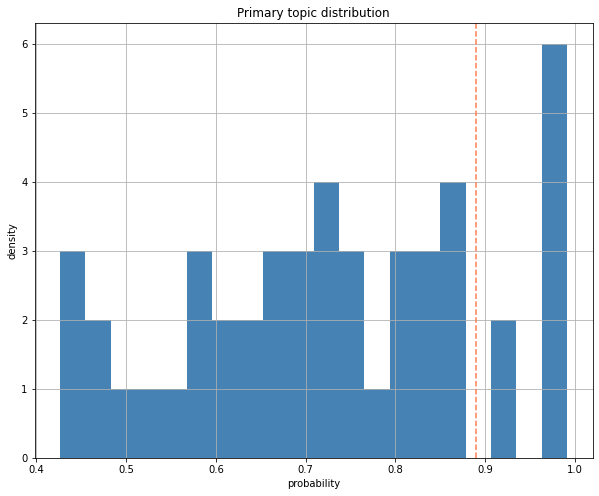

In [70]:
# df_prob_topic[1].hist(bins=20, figsize=(10,8), color='steelblue')
esg_group['probability'].hist(bins=20, figsize=(10,8), color='steelblue')

# plot distribution of main topic proability
plt.axvline(0.89, color='coral', linestyle='--')
plt.title('Primary topic distribution')
plt.xlabel('probability')
plt.ylabel('density')
plt.show()

## Highest probability statement for each topic

In [71]:
a = esg_group.loc[esg_group.groupby('topic')['probability'].idxmax()]
a

,lem,nr_words,topic,probability,probabilities
44,additional disclosures barclays plc environmen...,143,2,0.991426,"[0.0009525549634286377, 0.9914263160641641, 0...."
27,barclays plc environmental social governance r...,43,3,0.795126,"[0.003571819372353608, 0.003572039729521433, 0..."
13,make growth green sustainable and inclusive ba...,122,4,0.990216,"[0.0010870935344231216, 0.0010871919655620892,..."
2,barclays plc environmental social governance r...,123,5,0.818044,"[0.001449585550656578, 0.1160333418780411, 0.0..."
36,people with different perspective and life exp...,108,6,0.926112,"[0.0013335384567829827, 0.06321972146425188, 0..."
19,barclays esg carbon emission scope reduction f...,66,7,0.982690,"[0.001923123625167345, 0.0019231981289682945, ..."
10,sustainalytic risk rating scale with be the mo...,84,9,0.759187,"[0.0018183296307995563, 0.226264047069143, 0.0..."
21,manage our social and environmental impacts ba...,146,10,0.990720,"[0.001031086780610105, 0.0010311021752712024, ..."
